### packages

In [1]:
import numpy as np

import pandas as pd

################################################################################################
################################################################################################

import pulp

################################################################################################
################################################################################################

import networkx as nx

################################################################################################
################################################################################################


import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

import seaborn as sns

from matplotlib.transforms import Bbox

################################################################################################
################################################################################################


from scipy.optimize import minimize

### parameters


\begin{equation}
u_{o,d,i} = \overbrace{\alpha_{0,o}}^{\textrm{constant term}} - \overbrace{\alpha_{1,o} \cdot f_{o,d,i}}^{\textrm{order fare}} - \overbrace{ \alpha_{2,o} \cdot \tau_{o,d} }^{\textrm{pick-up time}}, \forall o \in O,
\label{eq:order utility}
\end{equation}

\begin{equation}
v_{o,d,i} = \overbrace{\beta_{0,d}}^{\textrm{constant term}} + \overbrace{\beta_{1,d} \cdot w_{o,d,i}}^{\textrm{wage}} - \overbrace{ \beta_{2,d} \cdot \tau_{o,d} }^{\textrm{pick-up time}}, \forall d \in D
\label{eq:driver utility}
\end{equation}

In [2]:
################################################################################################
################################################################################################

order_num=10

driver_num=10

################################################################################################
################################################################################################

theta_0=2.505

theta_1=0.355

theta_2=1.055

lambda_=0.755

################################################################################################
################################################################################################

alpha0=0.0

alpha1=3.2

alpha2=0.6

################################################################################################
################################################################################################

beta0=0.0

beta1=2.0

beta2=0.5

### generate data

\begin{align}
\begin{split}
&f_{o,d,2}=\theta_{0}+ \theta_{1}\cdot \textrm{ETD}_{o} + \theta_{2}\cdot \textrm{ETT}_{o}
\label{eq: linear fare}
\end{split}
\end{align}

\begin{align}
\begin{split}
&w_{o,d,2}=\lambda f_{o,d,2}
\label{eq: linear wage}
\end{split}
\end{align}

In [3]:
################################################################################################
################################################################################################

ETD=np.random.uniform(3,10,order_num)

ETT=np.random.uniform(3,10,order_num)

################################################################################################
################################################################################################

Fare2=theta_0*np.ones(order_num)+theta_1*ETD+theta_2*ETT

Fare2=np.tile(np.array([Fare2]).transpose(), (1,driver_num))

################################################################################################
################################################################################################

Wage2=lambda_*Fare2

################################################################################################
################################################################################################

Tau=np.random.uniform(3,10,[order_num,driver_num])

################################################################################################
################################################################################################

U2=alpha0*np.ones([order_num,driver_num])-alpha1*Fare2-alpha2*Tau

################################################################################################
################################################################################################

V2=beta0*np.ones([order_num,driver_num])+beta1*Wage2-beta2*Tau

################################################################################################
################################################################################################

u_decline=np.quantile(U2,0.25)

v_decline=np.quantile(V2,0.25)

print('Deline utility of passenger is ',u_decline)

print('Deline utility of driver is ',v_decline)


Deline utility of passenger is  -45.86058345934218
Deline utility of driver is  11.187277155452808


### Ride-matching of platform 2

\begin{align}
\begin{split}
&\max_{x_{o,d,2}} \mathbb{Q}= \sum_{o\in O} \sum_{d\in D}  (f_{o,d,2}-w_{o,d,2})  \cdot x_{o,d,2}
\label{eq:objective of platform 2}
\end{split}\\
\begin{split}
\text{subject to}&\sum_{d \in D} x_{o,d,2} \leq  1, \forall o \in O
\label{eq:constrain 1 of platform 2}
\end{split}\\
\begin{split}
&\sum_{o \in O} x_{o,d,2} \leq 1, \forall d \in D
\label{eq:constrain 2 of platform 2}
\end{split}
\end{align}

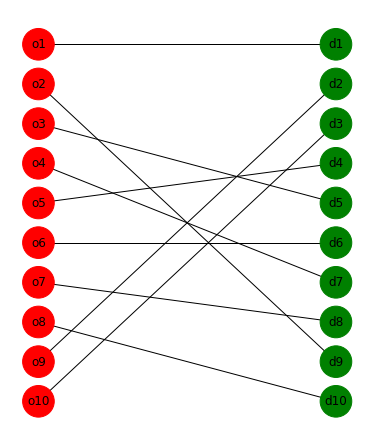

In [5]:
def Bipartite_matching(Weights):
    
    # model

    model = pulp.LpProblem("Ride_Matching_Problems", pulp.LpMaximize)

    # variables

    X = pulp.LpVariable.dicts("X",((O,D) for O in range(Weights.shape[0]) for D in range(Weights.shape[1])),lowBound=0,upBound=1,cat='Integer')

    # objective

    model += (pulp.lpSum([Weights[O,D] * X[(O, D)] for O in range(Weights.shape[0]) for D in range(Weights.shape[1])]))

    # constraints

    for O in range(Weights.shape[0]):

        model += pulp.lpSum([X[(O, D)] for D in range(Weights.shape[1])]) <= 1

    for D in range(Weights.shape[1]):

        model += pulp.lpSum([X[(O, D)] for O in range(Weights.shape[0])]) <= 1
            
    # solvable

    model.solve()
    
    x = np.zeros([Weights.shape[0],Weights.shape[1]])
    
    for var in X:

        var_value = X[var].varValue

        if var_value !=0:

            x [var[0]][var[1]]=1
            
    return x

################################################################################################
################################################################################################

Weights2=(Fare2-Wage2)/Tau

X2=Bipartite_matching(Weights2)

################################################################################################
################################################################################################

G2 = nx.Graph()

order_nodes=['o'+str(o+1) for o in range(order_num)]

driver_nodes=['d'+str(d+1) for d in range(driver_num)]

for node in order_nodes:
    
    G2.add_node(node, level=0)
    
for node in driver_nodes:
    
    G2.add_node(node, level=1)
    
################################################################################################
################################################################################################

for o in range(order_num):

    for d in range(driver_num):
        
        if X2[o][d]==1:

            G2.add_edge('o'+str(o+1),'d'+str(d+1))

################################################################################################
################################################################################################

color_map = ['red' if 'o' in node else 'green' for node in G2.nodes()]  

pos = nx.multipartite_layout(G2, subset_key="level")

plt.figure(figsize=(5,6)) 

nx.draw(G2,pos,with_labels = True,node_size=1000,node_color=color_map)

plt.show()
   
        

### Observable static competition

Fare and wage optimization, determines the optimal fare and wage for an arbitrary order-driver pair $(o,d)$, which maximizes the expected profit of such pair,

\begin{align}
\begin{split}
\max_{f_{o,d,1},w_{o,d,1}} \mathcal{P}(f_{o,d,1},w_{o,d,1}),\forall o \in O, \forall d \in D
\label{eq: pricing and waging objective}
\end{split}\\
\begin{split}
\text{subject to }&f_{o,d,1} \geq 0, \forall o \in O, \forall d \in D
\label{eq: pricing fare range}
\end{split}\\
\begin{split}
&w_{o,d,1} \geq 0, \forall o \in O, \forall d \in D.
\label{eq: pricing wage range}
\end{split}
\end{align}

\begin{equation}
\begin{aligned}
\mathcal{P}(f_{o,d,1},w_{o,d,1}|f_{o,d,2},w_{o,d,2},x_{o,d,2})=&   \frac{\textrm{exp}(u_{o,d,1})}{\textrm{exp}(u_{o}^{\textrm{c}})+\sum_{d \in D} \textrm{exp}(u_{o,d,2})\cdot x_{o,d,2}+\textrm{exp}(u_{o,d,1})}\\
& \cdot \frac{\textrm{exp}(v_{o,d,1})}{\textrm{exp}(v_{d}^{\textrm{c}})+\sum_{o \in O} \textrm{exp}(v_{o,d,2})\cdot x_{o,d,2}+ \textrm{exp}(v_{o,d,1})}  \cdot (f_{o,d,1}-w_{o,d,1}).
\label{eq: OS FW objective}
\end{aligned}
\end{equation}

Matching optimization, can be formulated as a maximum-weighted bipartite matching problem. A bipartite graph is first constructed to represent all the potential matches between passengers and drivers. A weighted edge connects each pair of the passenger and driver nodes, and the weight is the optimal expected profit $\mathcal{P}(f^{*}_{o,d,1},w^{*}_{o,d,1})$ of order-driver pair $(o,d)$, $\forall o \in O$, $\forall d \in D$, derived from Fare and wage optimization,

\begin{align}
\begin{split}
&\max_{x_{o,d,1}} \mathbb{P} = \sum_{o\in O}\sum_{d\in D}  \mathcal{P}(f^{*}_{o,d,1},w^{*}_{o,d,1})  \cdot x_{o,d,1}
\label{eq: matching objective}
\end{split}\\
\begin{split}
\text{subject to}&\sum_{d \in D} x_{o,d,1} \leq  1, \forall o \in O
\label{eq: matching constrain 1}
\end{split}\\
\begin{split}
&\sum_{o \in O} x_{o,d,1} \leq 1, \forall d \in D
\label{eq: matching constrain 2}
\end{split}\\
\begin{split}
&x_{o,d,1} \in \{0,1\}, \forall o \in O, \forall d \in D.
\label{eq: matching matching range}
\end{split}
\end{align}

In [6]:
class OS_optimization(object):
    
    ################################################################################################
    ################################################################################################
    
    def __init__(self,Fare2,Wage2,X2,U2,V2,u_decline,v_decline,Tau):
        
        ################################################################################################
        
        self.Fare2=Fare2 # fare of platform 2
        
        self.Wage2=Wage2 # wage of platform 2
        
        self.X2=X2 # matching solution of platform 2
        
        ################################################################################################
        
        self.U2=U2 # passenger utility of platform 2
        
        self.V2=V2 # driver utility of platform 2
        
        ################################################################################################
        
        self.u_decline=u_decline
        
        self.v_decline=v_decline
        
        ################################################################################################
        
        self.Tau=Tau # pickup time of platform 2
        
    ################################################################################################
        
    def profit(self,X,o,d):
        
        ################################################################################################
        
        u1=alpha0-alpha1*X[0]-alpha2*self.Tau[o,d]
        
        v1=beta0+beta1*X[1]-beta2*self.Tau[o,d]
        
        ################################################################################################
        
        u2=self.U2[o,d]
        
        v2=self.V2[o,d]
        
        ################################################################################################
        
        u0=self.u_decline
        
        v0=self.v_decline
        
        ################################################################################################
        
        p=np.exp(u1)/(np.exp(u0)+np.exp(u2)+np.exp(u1))
    
        q=np.exp(v1)/(np.exp(v0)+np.exp(v2)+np.exp(v1))
        
        ################################################################################################
        
        return -1*p*q*(X[0]-X[1])
    
    ################################################################################################
    
    def weights(self,Fare1,Wage1):
        
        ################################################################################################
        
        Weights=np.zeros([order_num,driver_num])
        
        ################################################################################################
        
        for o in range(order_num):

            for d in range(driver_num):
                
                X=[Fare1[o,d],Wage1[o,d]]
                
                Weights[o,d]=-1*self.profit(X,o,d)/self.Tau[o,d]
                
        return Weights
                
    ################################################################################################
    
    def solve(self):
        
        ################################################################################################
        
        order_num,driver_num=self.X2.shape[0],self.X2.shape[1]
        
        ################################################################################################
        
        Fare1,Wage1,X1=np.zeros([order_num,driver_num]),np.zeros([order_num,driver_num]),np.zeros([order_num,driver_num])
        
        U1,V1=np.zeros([order_num,driver_num]),np.zeros([order_num,driver_num])
        
        ################################################################################################
        
        for o in range(order_num):

            for d in range(driver_num):
                
                fw_opt = minimize(self.profit,[10,7],args=(o,d),bounds=((0, None), (0, None)))#self.Fare2[o,d],self.Wage2[o,d]
                
                if fw_opt.success:

                    Fare1[o,d]=fw_opt.x[0]

                    Wage1[o,d]=fw_opt.x[1]
                    
                else:
                    
                    print('fail')
                    

        ################################################################################################
        
        Weights=self.weights(Fare1,Wage1)
        
        X1=Bipartite_matching(Weights)
        
        ################################################################################################
        
        for o in range(order_num):

            for d in range(driver_num):
                
                U1[o,d]=alpha0-alpha1*Fare1[o,d]-alpha2*self.Tau[o,d]
                
                V1[o,d]=beta0+beta1*Wage1[o,d]-beta2*self.Tau[o,d]

        return Fare1,Wage1,X1,U1,V1

In [7]:
################################################################################################
################################################################################################

optimization=OS_optimization(Fare2,Wage2,X2,U2,V2,u_decline,v_decline,Tau)

Fare1,Wage1,X1,U1,V1=optimization.solve()

################################################################################################
################################################################################################

G1 = nx.Graph()

for node in order_nodes:
    
    G1.add_node(node, level=0)
    
for node in driver_nodes:
    
    G1.add_node(node, level=1)

for o in range(order_num):

    for d in range(driver_num):
        
        if X1[o][d]==1:

            G1.add_edge('o'+str(o+1),'d'+str(d+1))

################################################################################################
################################################################################################

Fare1_df=pd.DataFrame(Fare1,columns=['d'+str(i+1) for i in range(driver_num)],index=['o'+str(i+1) for i in range(order_num)])

Wage1_df=pd.DataFrame(Wage1,columns=['d'+str(i+1) for i in range(driver_num)],index=['o'+str(i+1) for i in range(order_num)])

Fare2_df=pd.DataFrame(Fare2,columns=['d'+str(i+1) for i in range(driver_num)],index=['o'+str(i+1) for i in range(order_num)])

Wage2_df=pd.DataFrame(Wage2,columns=['d'+str(i+1) for i in range(driver_num)],index=['o'+str(i+1) for i in range(order_num)])


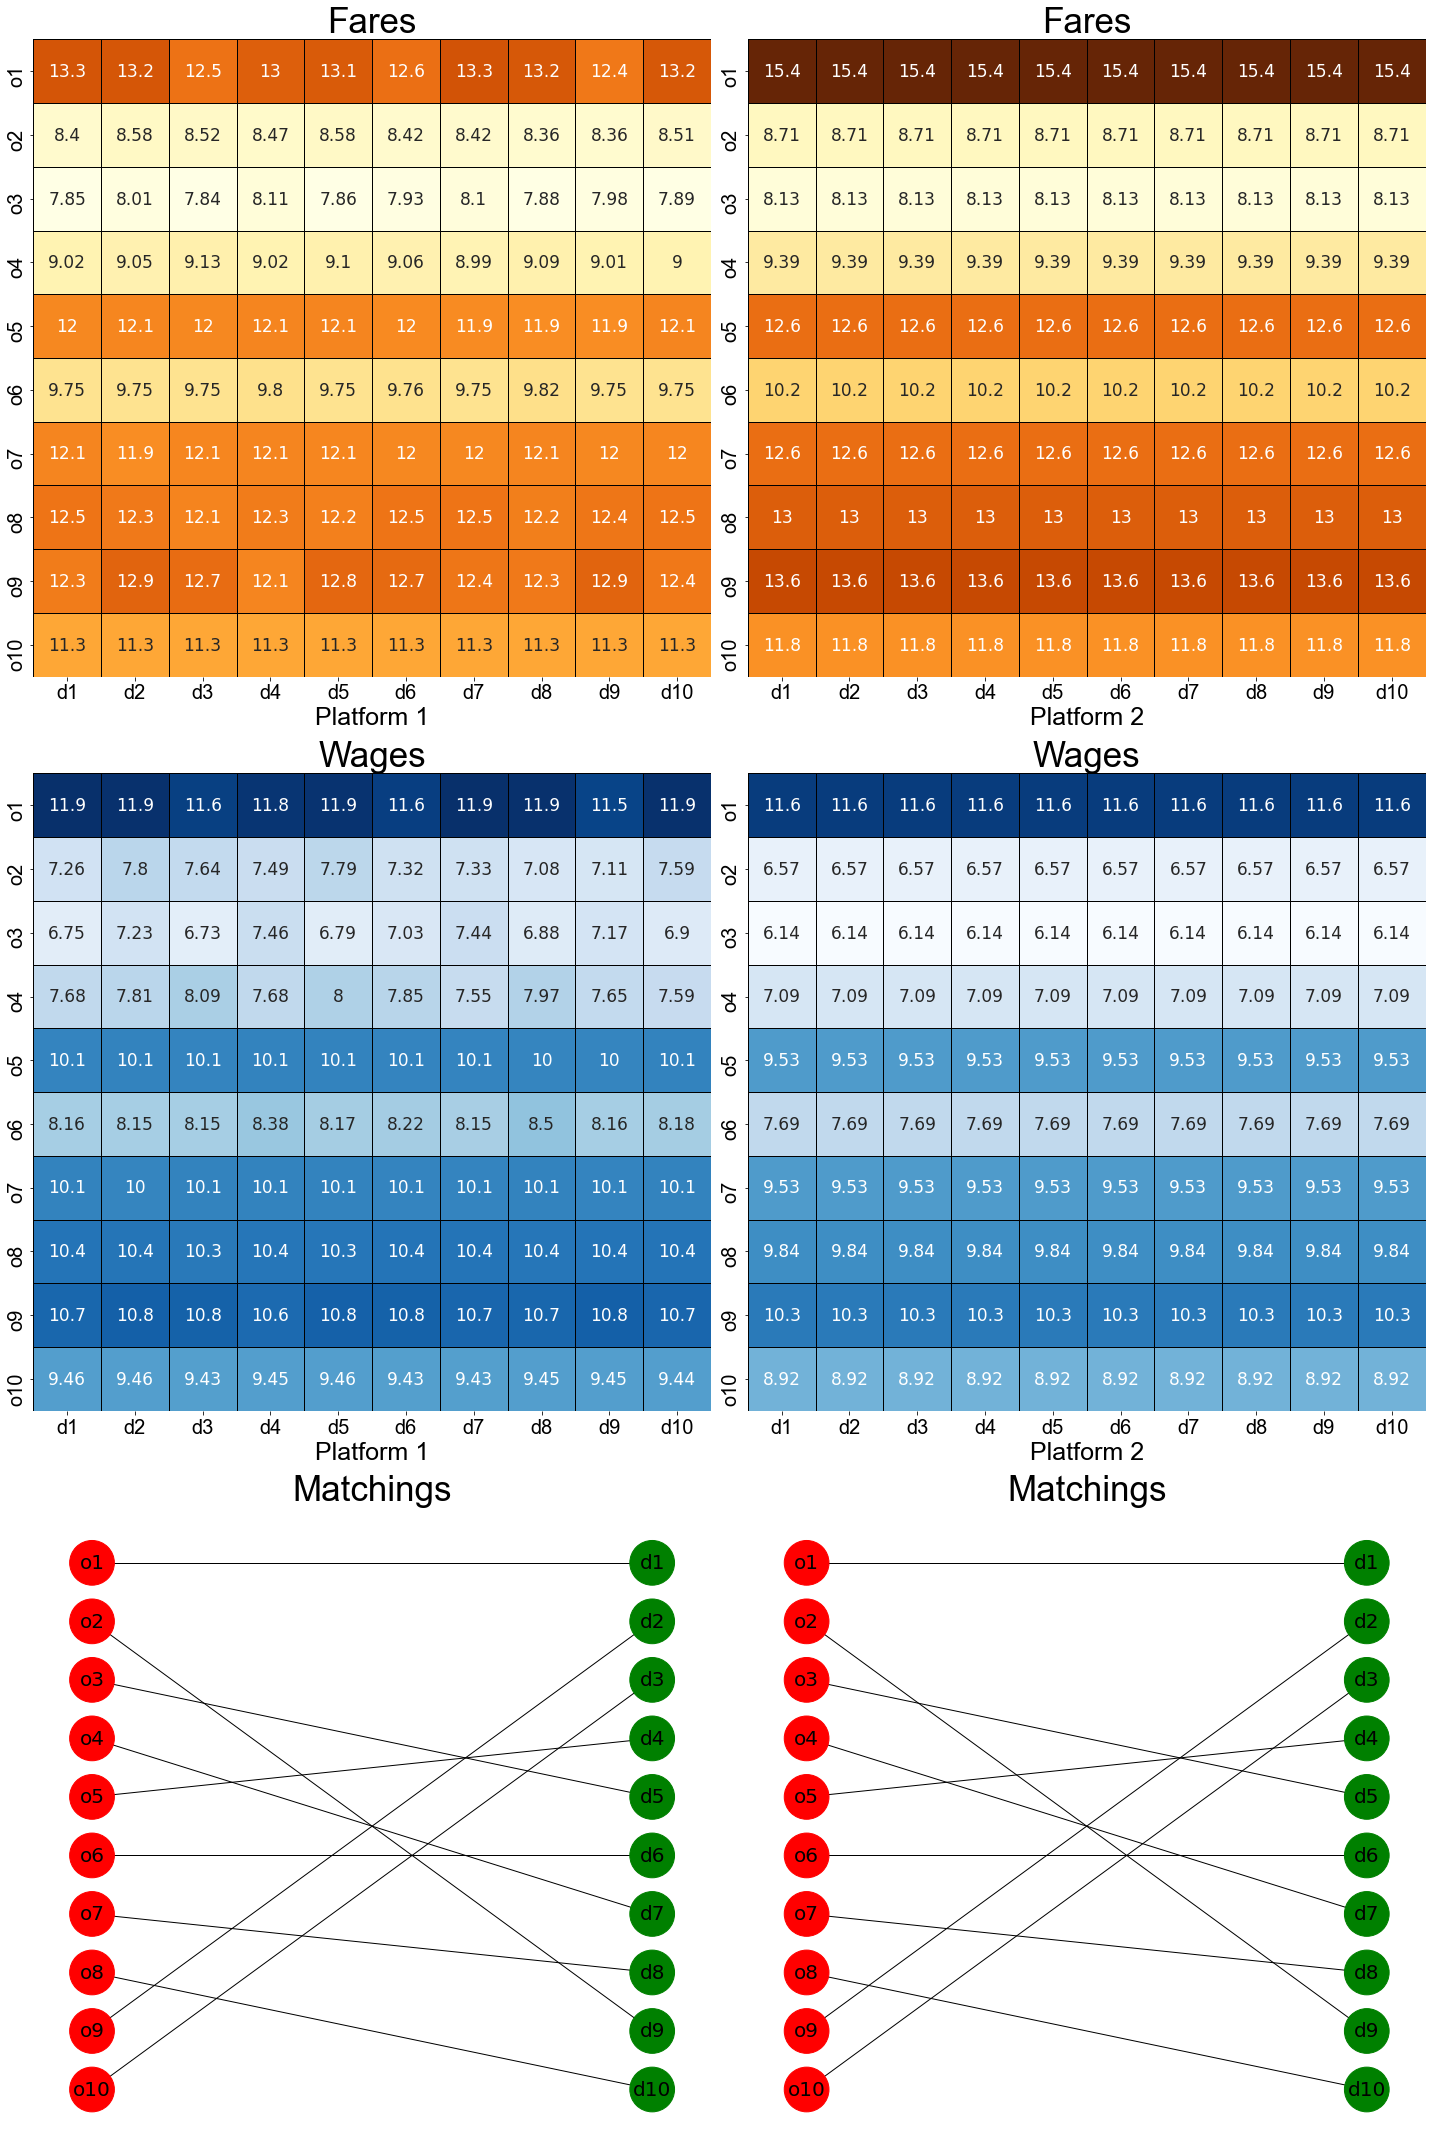

In [8]:
################################################################################################
################################################################################################

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

font_title = {'family' : 'Arial','weight' : 'normal','size': 35}

font_label = {'family' : 'Arial','weight' : 'normal','size': 25}

fig, axs = plt.subplots(3,2,figsize = (20,30))

################################################################################################
################################################################################################


for i in range(3):
    
    for j in range(2):
    
        labels = axs[i,j].get_xticklabels() + axs[i,j].get_yticklabels()

        [label.set_fontsize(20) for label in labels]

        [label.set_fontname('Arial') for label in labels]
        
################################################################################################
################################################################################################


fmin = min(Fare1_df.values.min(), Fare2_df.values.min())

fmax = max(Fare1_df.values.max(), Fare2_df.values.max())


sns.heatmap(Fare1_df, annot=True, linecolor='black',linewidths=.5,ax=axs[0,0],\
            fmt='.3g',cmap="YlOrBr",cbar=False,annot_kws={"size":17},\
            vmin=fmin,vmax=fmax)

axs[0,0].set_xlabel('Platform 1',font_label)

axs[0,0].set_title('Fares',font_title)

sns.heatmap(Fare2_df, annot=True, linecolor='black',linewidths=.5,ax=axs[0,1],\
            fmt='.3g',cmap="YlOrBr",cbar=False,annot_kws={"size":17},\
            vmin=fmin,vmax=fmax)

axs[0,1].set_xlabel('Platform 2',font_label)

axs[0,1].set_title('Fares',font_title)

################################################################################################
################################################################################################

wmin = min(Wage1_df.values.min(), Wage2_df.values.min())

wmax = max(Wage1_df.values.max(), Wage2_df.values.max())


sns.heatmap(Wage1_df, annot=True, linecolor='black',linewidths=.5,ax=axs[1,0],\
            fmt='.3g',cmap="Blues",cbar=False,annot_kws={"size":17},\
            vmin=wmin,vmax=wmax)

axs[1,0].set_xlabel('Platform 1',font_label)

axs[1,0].set_title('Wages',font_title)

sns.heatmap(Wage2_df, annot=True, linecolor='black',linewidths=.5,ax=axs[1,1],\
            fmt='.3g',cmap="Blues",cbar=False,annot_kws={"size":17},\
            vmin=wmin,vmax=wmax)

axs[1,1].set_xlabel('Platform 2',font_label)

axs[1,1].set_title('Wages',font_title)


################################################################################################
################################################################################################

color_map = ['red' if 'o' in node else 'green' for node in G1.nodes()]  

pos = nx.multipartite_layout(G1, subset_key="level")

nx.draw(G1,pos,with_labels = True,node_size=2000,node_color=color_map,ax=axs[2,0],font_size=20)

axs[2,0].set_title('Matchings',font_title)

################################################################################################

color_map = ['red' if 'o' in node else 'green' for node in G2.nodes()]  

pos = nx.multipartite_layout(G2, subset_key="level")

nx.draw(G2,pos,with_labels = True,node_size=2000,node_color=color_map,ax=axs[2,1],font_size=20)

axs[2,1].set_title('Matchings',font_title)

################################################################################################
################################################################################################


plt.tight_layout()


current_fig = plt.gcf() 

current_fig.savefig(('solution.eps'), format='eps', dpi=1000, bbox_inches = 'tight')



plt.show()



In [9]:
################################################################################################
################################################################################################
################################################################################################
################################################################################################


def Choice(Fare1,Wage1,X1,U1,V1,Fare2,Wage2,X2,U2,V2,u_decline,v_decline):
    
    ################################################################################################
    ################################################################################################
        
    order_num,driver_num=X2.shape[0],X2.shape[1]
    
    ################################################################################################
    ################################################################################################
    
    order_selection={}
    
    driver_selection={}
    
    ################################################################################################
    ################################################################################################
    
    for o  in range(order_num):
        
        ################################################################################################
        ################################################################################################
        
        choice_set={'decline':u_decline}
        
        ################################################################################################
        ################################################################################################
        
        matching1,matching2=np.nonzero(X1[o,:])[0],np.nonzero(X2[o,:])[0]
        
        if len(matching1)>0:
        
            d1=matching1[0]
            
            choice_set['1']=U1[o,d1]
            
        if len(matching2)>0:
            
            d2=matching2[0]
            
            choice_set['2']=U2[o,d2]
            
        ################################################################################################
        ################################################################################################
        
        choice_prob={}
        
        exp_sum=sum([np.exp(u) for u in choice_set.values()])
        
        for select,utility in choice_set.items():
            
            choice_prob[select]=np.exp(utility)/exp_sum
            
        ################################################################################################
        ################################################################################################
        
        selection=np.random.choice(list(choice_prob.keys()),p=list(choice_prob.values()))
        
        if selection=='1':
            
            selection=selection+'_'+str(matching1[0])
            
        elif selection=='2':
            
            selection=selection+'_'+str(matching2[0])
            
        else:
            
            selection=selection+'_null'
            
        order_selection[o]=selection
        
    ################################################################################################
    ################################################################################################
    
    for d  in range(driver_num):
        
        ################################################################################################
        ################################################################################################
        
        choice_set={'decline':v_decline}
        
        ################################################################################################
        ################################################################################################
        
        matching1,matching2=np.nonzero(X1[:,d])[0],np.nonzero(X2[:,d])[0]
        
        if len(matching1)>0:
        
            o1=matching1[0]
            
            choice_set['1']=V1[o1,d]
            
        if len(matching2)>0:
            
            o2=matching2[0]
            
            choice_set['2']=V2[o2,d]
            
        ################################################################################################
        ################################################################################################
        
        choice_prob={}
        
        exp_sum=sum([np.exp(u) for u in choice_set.values()])
        
        for select,utility in choice_set.items():
            
            choice_prob[select]=np.exp(utility)/exp_sum
            
        ################################################################################################
        ################################################################################################
        
        selection=np.random.choice(list(choice_prob.keys()),p=list(choice_prob.values()))
        
        if selection=='1':
            
            selection=selection+'_'+str(matching1[0])
            
        elif selection=='2':
            
            selection=selection+'_'+str(matching2[0])
            
        else:
            
            selection=selection+'_null'
            
        driver_selection[d]=selection
        
    ################################################################################################
    ################################################################################################

    profit={'1':0,'2':0}
    
    matchings={'1':[],'2':[]}
    
    ################################################################################################
    ################################################################################################
    
    for o,order_select in order_selection.items():
        
        order_platform,d=order_select.split('_')[0],order_select.split('_')[1]
        
        if order_platform!="decline":
            
            d=int(d)
            
            driver_select=driver_selection[d]
            
            driver_platform=driver_select.split('_')[0]
            
            if driver_platform==order_platform:
                
                matchings[driver_platform].append((o,d))
                
                if driver_platform=='1':
                    
                    profit[driver_platform]+=Fare1[o,d]-Wage1[o,d]
                    
                elif driver_platform=='2':
                    
                    profit[driver_platform]+=Fare2[o,d]-Wage2[o,d]
                    
    ################################################################################################
    ################################################################################################

    return profit,matchings


        


### user example and simulate the choice behaviour

In [10]:
Choice(Fare1,Wage1,X1,U1,V1,Fare2,Wage2,X2,U2,V2,u_decline,v_decline)

({'1': 7.906939077021933, '2': 2.133584268530572},
 {'1': [(4, 3), (6, 7), (8, 1), (9, 2)], '2': [(1, 8)]})

### save sub figure

In [11]:
########################################################################################################
########################################################################################################
########################################################################################################
########################################################################################################

def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)

########################################################################################################
########################################################################################################

extent = full_extent(axs[1,0]).transformed(fig.dpi_scale_trans.inverted())

fig.savefig('subfigure.png', bbox_inches=extent)

########################################################################################################
########################################################################################################

### dynamic figure

In [18]:
profits=list()

for i in range(1000):

    optimization=OS_optimization(Fare2,Wage2,X2,U2,V2,u_decline,v_decline,Tau)

    Fare1,Wage1,X1,U1,V1=optimization.solve()

    profit,matchings=Choice(Fare1,Wage1,X1,U1,V1,Fare2,Wage2,X2,U2,V2,u_decline,v_decline)

    profits.append(profit['1'])
    
profits

[8.247291651117125,
 11.987956986631636,
 12.393042993332045,
 9.002526779529708,
 10.210793557536109,
 7.489630204974334,
 8.08756458665018,
 8.057151802571031,
 11.120549574595485,
 10.014595176949474,
 8.297276799521434,
 11.969451917629595,
 10.065837885987204,
 5.532982400847416,
 11.875784703008067,
 9.552031063048092,
 5.21537395849494,
 12.83011824485973,
 6.7914703404580745,
 7.330824205711119,
 8.762889537503034,
 8.269787144570298,
 4.968551572999399,
 10.154111020586662,
 6.738128752645752,
 10.50214722372275,
 7.493363881058334,
 4.985114029364237,
 10.50214722372275,
 9.181015661365826,
 9.854868112482528,
 13.671835444424973,
 12.076230121231093,
 11.352227380327722,
 10.836629493941814,
 8.900660065583072,
 10.783680633076367,
 8.895623080976003,
 6.871380518017803,
 13.857509469729958,
 7.314261749346281,
 4.905203851804508,
 8.778728225744194,
 7.509313087547238,
 8.482533941720279,
 8.614089671622386,
 5.924232119635008,
 8.712668375898776,
 8.688512478507533,
 11.17

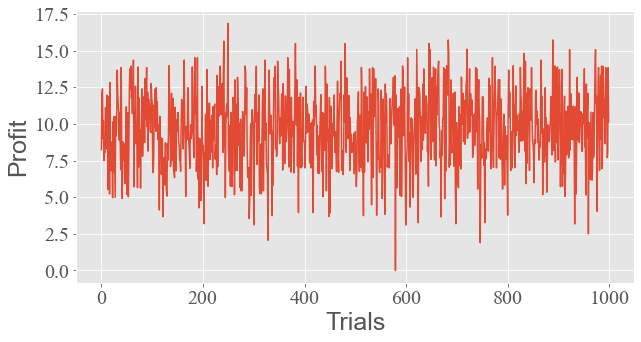

In [20]:
plt.style.use('ggplot')

def get_running_reward(reward_array: np.ndarray, window=100):
    
    """calculate the running reward, i.e. average of last `window` elements from rewards"""
    
    running_reward = np.zeros_like(reward_array)
    
    for i in range(window - 1):
        
        running_reward[i] = np.mean(reward_array[:i + 1])
        
    for i in range(window - 1, len(reward_array)):
        
        running_reward[i] = np.mean(reward_array[i - window + 1:i + 1])
        
    return running_reward

########################################################################################################
########################################################################################################

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 25}

fig, axs = plt.subplots(figsize = (10,5))

labels = axs.get_xticklabels() + axs.get_yticklabels()

[label.set_fontsize(20) for label in labels]

[label.set_fontname('Times New Roman') for label in labels]

# axs.grid()

########################################################################################################
########################################################################################################

# axs.plot(range(iteration_df.shape[0]), iteration_df.reward)

axs.plot(range(1000), profits)
    
########################################################################################################
########################################################################################################

axs.set_xlabel('Trials',font_label)

axs.set_ylabel('Profit',font_label)


current_fig = plt.gcf() 

current_fig.savefig(('profits.eps'), format='eps', dpi=1000, bbox_inches = 'tight')


plt.show()